# Data visualization

In [1]:
import os
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "/content/drive/MyDrive/Tidy_Python_2025/"
%cd $gdrive_path

Mounted at /content/drive
/content/drive/MyDrive/Tidy_Python_2025


## Deep look into the data
- Visualize patterns, identify possible errors (logical or numerical)
- Consider adding clearcut cleaning steps into our pipeline in nb2.
- Modularize operations for reuse, chaining, and logging.

In [ ]:
# !rm -r 2025-tidy-python
# !git clone https://github.com/Py-ualg/2025-tidy-python.git

In [3]:
data_tidy_path = gdrive_path + 'tidy-data/'

In [4]:
crabs = pd.read_parquet(os.path.join(data_tidy_path, 'crabs.parquet'))

In [5]:
crabs.head()

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth,associated_species,behaviour
0,Ria Alvor,2020-01-02,Uca olhanensis,female,juvenile,False,0.749001,0.672986,3.454545,0.969131,0.715282,7.0,"['Sea Sponge', 'Shrimp', 'Sea Star']",Collecting biofilm from sunken wood.
1,Ria Alvor,2020-01-02,Afruca farensis,NaN,sub_adult,None,3.176997,3.522727,3.454545,4.634476,3.790048,9.0,"['Snail', 'Sea Sponge', 'Algae', 'Sea Star']",Side-stepping along sandy coastal floor.
2,Ria Alvor,2020-01-02,Uca olhanensis,NaN,sub_adult,None,0.591866,0.568182,3.727273,0.748647,0.618259,11.0,['Snail'],Guarding eggs beneath body flap.
3,Ria Alvor,2020-01-02,Uca olhanensis,male,adult,None,3.426632,3.272727,3.727273,4.336083,3.471059,7.0,"['Sea Urchin', 'Polychaete Worm']",Swiftly dashing across exposed sand.
4,Ria Alvor,2020-01-02,Uca olhanensis,female,adult,False,3.126850,3.315087,3.636364,4.384256,3.536922,3.0,"['Hermit Crab', 'Sea Sponge', 'Jellyfish', 'Ba...",Gradual movement in cold conditions.


In [6]:
crabs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23824 entries, 0 to 23823
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region              23824 non-null  category      
 1   date                23824 non-null  datetime64[ns]
 2   species             23824 non-null  category      
 3   sex                 21801 non-null  category      
 4   stage               23824 non-null  category      
 5   is_gravid           12019 non-null  object        
 6   carapace_width      23824 non-null  float64       
 7   carapace_length     23824 non-null  float64       
 8   front_width         23824 non-null  float64       
 9   left_claw_length    23824 non-null  float64       
 10  right_claw_length   23824 non-null  float64       
 11  depth               23824 non-null  float64       
 12  associated_species  23824 non-null  object        
 13  behaviour           23824 non-null  object    

### Numerical columns

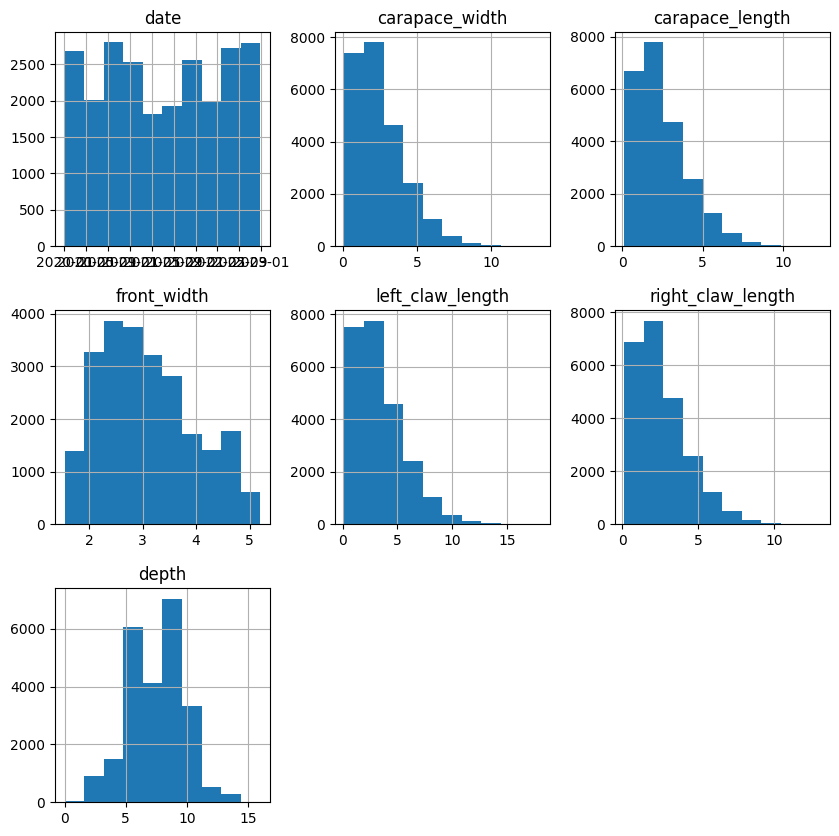

In [7]:
crabs.hist(figsize=(10, 10));

### Remove negative values
- we have done it in nb2, however you can imagine you might have missed it and notice it only here.
- Try not to be lazy, and fix it upstream

In [8]:
#@title Remove negative values
crabs1 = crabs[crabs['right_claw_length'] > 0]
crabs1 = crabs1[crabs1['left_claw_length'] > 0]
crabs1.shape, crabs.shape


((23824, 14), (23824, 14))

In [9]:
#@title Reconcile integer vs Float values

# rename
crabs1.rename(columns={'depth [m]': 'depth'}, inplace=True)

# map columns as integers
crabs1 = crabs1.astype({
    'depth': int,
})

In [10]:
crabs1.describe()

,date,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth
count,23824,23824.000000,23824.000000,23824.000000,23824.000000,23824.000000,23824.000000
mean,2021-07-04 08:48:30.946944256,2.508782,2.479643,3.114744,3.387991,2.604520,7.360813
min,2020-01-02 00:00:00,0.123718,0.131395,1.545455,0.171086,0.132600,0.000000
25%,2020-09-29 00:00:00,1.234451,1.227273,2.400000,1.654192,1.294344,6.000000
50%,2021-07-13 00:00:00,2.142766,2.113636,3.000000,2.881698,2.223192,7.000000
75%,2022-04-08 00:00:00,3.423904,3.375000,3.636364,4.614052,3.537980,9.000000
max,2022-12-28 00:00:00,13.284025,12.300000,5.200000,18.040867,13.058792,16.000000
std,NaN,1.657507,1.623611,0.858202,2.256039,1.708114,2.265140


#### Extreme values

Is 18 cm for left_claw_length reasonable? What do you do?
- cutoff?, drop rows? Where?
- For normal distribution, outlier can be for instance `mean +- 3STD`. This is not Normal distribution, so apply or not apply?
- Other statistical test
- **Domain knowledge**

In [11]:
#@ Tukey's method
# Compute the interquartile range (IQR): IQR = Q3 - Q1
# Define outliers as values:
#     Below Q1 - 1.5 * IQR
#     Above Q3 + 1.5 * IQR

q1 = crabs1['left_claw_length'].quantile(0.25)
q3 = crabs1['left_claw_length'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = crabs1[(crabs1['left_claw_length'] < lower) | (crabs1['left_claw_length'] > upper)]

In [12]:
outliers

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth,associated_species,behaviour
118,Ria Alvor,2020-01-02,Afruca farensis,male,sub_adult,None,8.109561,6.818182,3.727273,11.230465,7.281539,9,"['Sea Star', 'Small Fish', 'Coral Fragment']",Retreating swiftly from perceived danger.
134,Ria Alvor,2020-01-02,Afruca farensis,male,adult,None,6.678878,6.136364,3.545455,9.939242,6.382356,3,"['Jellyfish', 'Hermit Crab', 'Coral Fragment']",Approaching small fish with curiosity.
137,Ria Alvor,2020-01-02,Afruca farensis,female,adult,True,6.339533,6.284337,3.818182,9.174375,6.735645,5,"['Algae', 'Shrimp', 'Sea Sponge', 'Small Fish'...",Lying still to avoid detection.
226,Ria Alvor,2020-01-02,Afruca farensis,female,adult,False,7.470414,6.961568,3.545455,9.439580,7.376145,4,"['Shrimp', 'Mussel', 'Sea Urchin']",Guarding eggs beneath body flap.
242,Ria Alvor,2020-01-02,Afruca farensis,male,adult,None,7.147685,6.681818,3.545455,9.533175,7.001385,8,"['Sea Anemone', 'Hermit Crab', 'Snail']",Resting in shaded crevice along cliff.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23749,Ria Formosa,2022-12-28,Uca olhanensis,male,adult,None,7.977978,7.350000,1.900000,11.889898,7.603413,7,"['Polychaete Worm', 'Sea Anemone', 'Barnacle',...",Foraging through tangled seagrass roots.
23762,Ria Formosa,2022-12-28,Afruca farensis,male,sub_adult,None,7.027051,5.875000,1.700000,10.063844,6.377330,8,"['Algae', 'Sea Star', 'Mussel']",Harvesting food beneath floating debris.
23783,Ria Formosa,2022-12-28,Uca olhanensis,female,sub_adult,False,7.768452,8.053071,2.000000,9.978727,8.673284,10,"['Crab (Other Species)', 'Snail', 'Coral Fragm...",Scavenging at the edge of tidal pools.
23796,Ria Formosa,2022-12-28,Uca olhanensis,male,adult,None,7.398205,6.750000,2.000000,10.310803,6.763911,7,"['Hermit Crab', 'Mussel', 'Barnacle', 'Sea Star']",Traversing algae-slick rock surfaces.


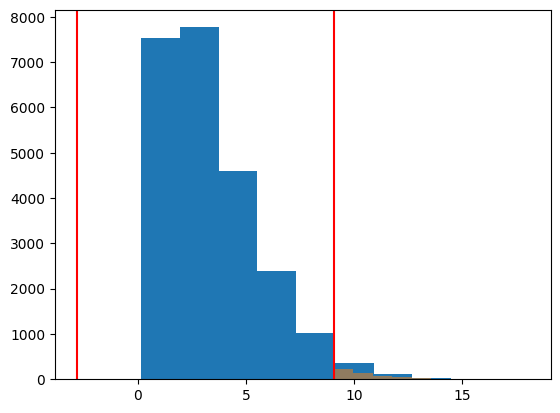

In [13]:
plt.hist(crabs1['left_claw_length'])
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')
plt.hist(outliers['left_claw_length'], alpha=0.5)
plt.show()

#### Exercise *1*: fix the histogram plot
- set bins + yaxis as *logscale*

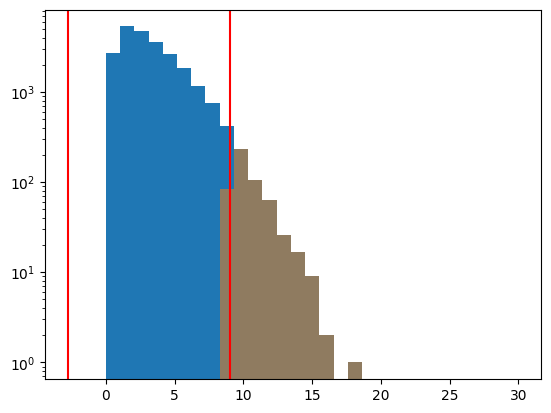

In [14]:
#@title Solution

bins = np.linspace(0, 30, 30)
plt.hist(crabs1['left_claw_length'], bins=bins)
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')
plt.hist(outliers['left_claw_length'], bins=bins, alpha=0.5)
plt.yscale('log')
plt.show()

#### Exercise 2: make the IQR into a function

In [15]:
#@title Solution
def get_iqr(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Compute the interquartile range (IQR) for a given column in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        col (str): The name of the column for which to compute the IQR.

    Returns:
        tuple: A tuple containing the lower and upper bounds of the IQR.
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

In [16]:
def modified_z_score(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Compute the modified z-score for a given column in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        col (str): The name of the column for which to compute the modified z-score.

    Returns:
        pandas.DataFrame: A new DataFrame with the modified z-score for the specified column.
    """

    x = df[col].dropna()
    median = np.median(x)
    mad = np.median(np.abs(x - median))
    mod_z = 0.6745 * (x - median) / mad

    outliers = df.loc[np.abs(mod_z) > 3.5]
    return outliers

In [17]:
def get_outliers_std(df: pd.DataFrame, col: str, std_cutoff=3) -> pd.DataFrame:
    x = df[col].dropna()
    mean = np.mean(x)
    std = np.std(x)
    outliers = df.loc[np.abs(x - mean) > std_cutoff * std]
    return outliers

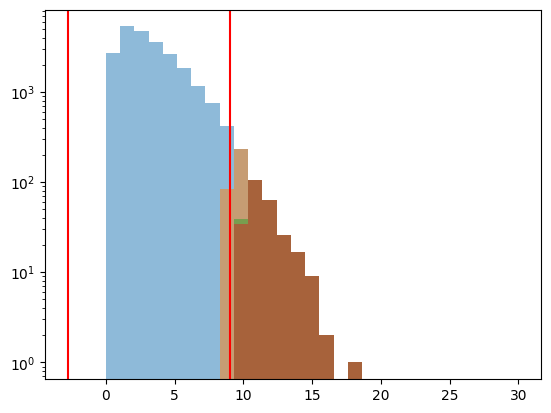

In [18]:
outliers_iqr = get_iqr(crabs1, 'left_claw_length')
outliers_z = modified_z_score(crabs1, 'left_claw_length')
outliers_std = get_outliers_std(crabs1, 'left_claw_length')

bins = np.linspace(0, 30, 30)
plt.hist(crabs1['left_claw_length'], bins=bins, alpha=0.5)
plt.hist(outliers_iqr['left_claw_length'], bins=bins, alpha=0.5)
plt.hist(outliers_z['left_claw_length'], bins=bins, alpha=0.5)
plt.hist(outliers_std['left_claw_length'], bins=bins, alpha=0.5)


plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')
plt.yscale('log')
plt.show()

### Drop or not to drop?
- in any case, perhaps we want to log these events for future reference
- `logging` module

In [34]:
import logging

logging_path = gdrive_path + 'logs/'
!mkdir -p $logging_path
log_file = os.path.join(logging_path, "nb3.log")

# set up logging
logging.basicConfig(
    filename=log_file,
    filemode='a',  # Use 'w' to overwrite on each run
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Remove all handlers associated with the root logger object.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.info("Logging is configured and ready!")

In [33]:
# there is always only now exression in logger, not like a print
# f-strings are not fully backwards compatible, but I personally use them. Purists use it as below
logging.info("Dropping %d outliers and resetting index", len(outliers_std))
crabs2 = crabs1.drop(outliers_std.index).reset_index(drop=True)
logging.info("Resulting DataFrame has %d rows", len(crabs2))

This is a good start, but to avoid sensitivity to variable name changes, it would be better to have this in a functions

### Categorical features

In [ ]:
#@title What would not make sense?

crabs2[(crabs2['sex'] == 'male') & (crabs2['is_gravid'] == True)]

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth,associated_species,behaviour
10,Ria Formosa,2022-07-29,Uca olhanensis,male,sub_adult,True,5.451751,4.875,2.3,7.512280,5.135812,9,['Shrimp'],Hiding in sandy burrow.
60,Ria Formosa,2022-07-29,Ucides alvorensis,male,adult,True,2.510632,2.700,2.4,3.372901,2.807410,7,"['Algae', 'Hermit Crab', 'Polychaete Worm', 'B...",Retreating into burrow.
70,Ria Formosa,2022-07-29,Uca olhanensis,male,adult,True,1.743315,1.650,2.3,2.133881,1.776254,7,"['Small Fish', 'Hermit Crab', 'Coral Fragment'...",Claw snapping in competition.
198,Ria Formosa,2022-07-29,Uca olhanensis,male,sub_adult,True,3.951287,4.625,2.4,5.505601,5.045265,9,"['Crab (Other Species)', 'Sea Star', 'Small Fi...",Interacting with small fish nearby.
208,Ria Formosa,2022-07-29,Afruca farensis,male,adult,True,6.790735,6.600,2.4,8.443809,6.894717,7,['Mussel'],Struggling with entangled seaweed.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21733,Ria Formosa,2022-11-28,Uca olhanensis,male,pre_puberty,True,5.224589,5.025,2.0,7.263440,5.238937,7,"['Jellyfish', 'Sea Star', 'Hermit Crab', 'Cora...",Vibrating antennae in water currents.
21753,Ria Formosa,2022-11-28,Uca olhanensis,male,sub_adult,True,3.467178,4.000,2.0,5.052266,4.031389,7,"['Small Fish', 'Crab (Other Species)', 'Snail'...",Resting under shell fragment.
21771,Ria Formosa,2022-11-28,Uca olhanensis,male,adult,True,4.567721,4.200,2.1,6.273636,4.412566,9,['Barnacle'],Burrowing into sandy sediment.
21780,Ria Formosa,2022-11-28,Uca olhanensis,male,sub_adult,True,4.926333,5.750,2.1,7.153365,6.225127,10,"['Hermit Crab', 'Algae', 'Snail', 'Jellyfish',...",Retreating quickly from shadow.


In [ ]:
crabs2['is_gravid'].value_counts()

,count
is_gravid,
False,6904
True,4231


1. First, pregnant males make up to 10% of all the samples,
2. Second even worse, compared to total count, it is the same amount of identified female pregnant.
3. Those are serious flaws which need domain knowledge, discussion with collaborators.

**What is the most correct thing to do for us now?**

In [ ]:
crabs2.drop(columns=['is_gravid'], inplace=True)

### Drop NA values

In [ ]:
crabs2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21833 entries, 0 to 21832
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region              21833 non-null  category      
 1   date                21833 non-null  datetime64[ns]
 2   species             21833 non-null  category      
 3   sex                 20002 non-null  category      
 4   stage               21833 non-null  category      
 5   carapace_width      21833 non-null  float64       
 6   carapace_length     21833 non-null  float64       
 7   front_width         21833 non-null  float64       
 8   left_claw_length    21833 non-null  float64       
 9   right_claw_length   21833 non-null  float64       
 10  depth               21833 non-null  int64         
 11  associated_species  21833 non-null  object        
 12  behaviour           21833 non-null  object        
dtypes: category(4), datetime64[ns](1), float64(5),

In [ ]:
crabs2['sex'].value_counts()

,count
sex,
male,10114
female,9888


In [ ]:
crabs2['sex'].unique()

['female', 'male', NaN]
Categories (2, object): ['female', 'male']

This way we can keep the numerical values, even though the `sex` data is missing for 25% of samples.

## Final data
- now we cleaned and crosscheck the "clean data again"
- You can try to push these step to nb2, where it pertains, however the questions we asked here logically pertain to the greay area with no exact correct answer, so you might want it separate as here.*italicized text*
- Now we really are after **visualization**

### Barplots

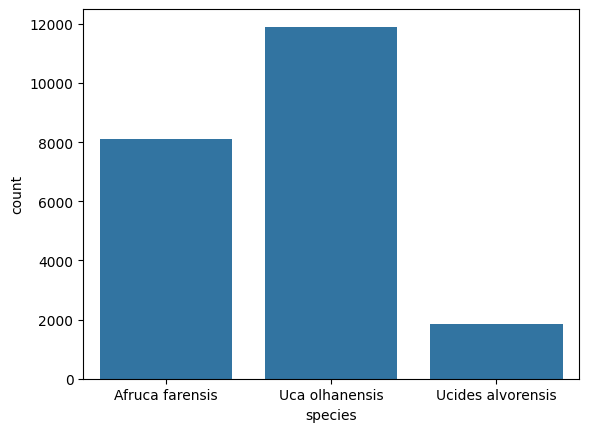

In [ ]:
sns.barplot(crabs2['species'].value_counts())
plt.show()

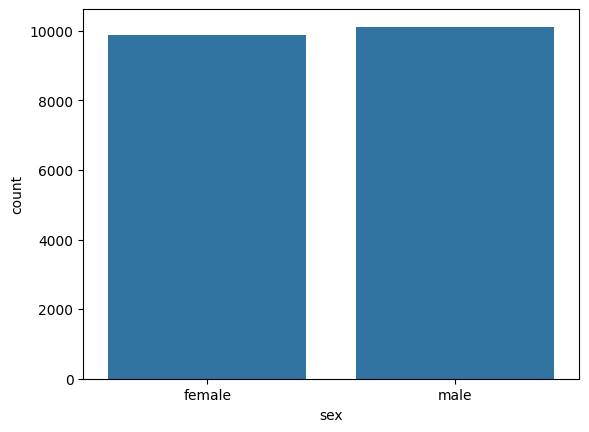

In [ ]:
sns.barplot(crabs2['sex'].value_counts(dropna=False))
plt.show()

**Careful**: we set two categories in the previous NB, therefore the NaNs are not appearing on the plot

<Axes: xlabel='sex', ylabel='count'>

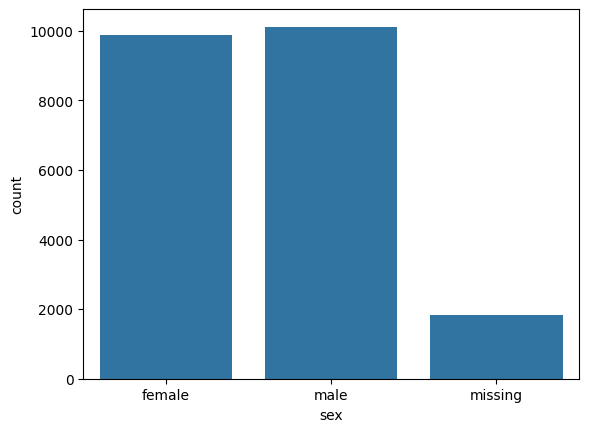

In [ ]:
crabs2['sex'] = crabs2['sex'].cat.add_categories('missing').fillna('missing')
sns.countplot(data=crabs2, x='sex')

In [ ]:
crabs2['sex'].unique()

['female', 'male', 'missing']
Categories (3, object): ['female', 'male', 'missing']

In [ ]:
crabs2['sex'].describe()

,sex
count,21833
unique,3
top,male
freq,10114


#### Exercise:
Can you visually show the crab abundance by species and sex in the same plot?

**R code**

```
nr_crabs_by_sp_sex <- count(crabs2, species, sex)
ggplot(data = nr_crabs_by_sp_sex, mapping = aes(x = species, y = n, fill = sex)) + geom_col()
```

/tmp/ipython-input-32-2839343411.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nr_crabs_by_sp_sex = crabs3.groupby(['species', 'sex']).size().reset_index(name='n')


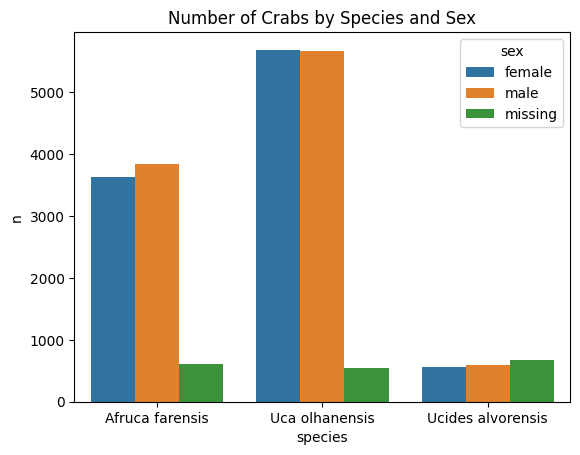

In [ ]:
# Count the number of crabs by species and sex
# sns.set_style()
crabs3 = crabs2.copy()
# crabs3['sex'].fillna('Missing', inplace=True)
nr_crabs_by_sp_sex = crabs3.groupby(['species', 'sex']).size().reset_index(name='n')

# Plotting
sns.barplot(data=nr_crabs_by_sp_sex, x='species', y='n', hue='sex')
plt.title('Number of Crabs by Species and Sex')
plt.show()

### Alternative using `catplot`

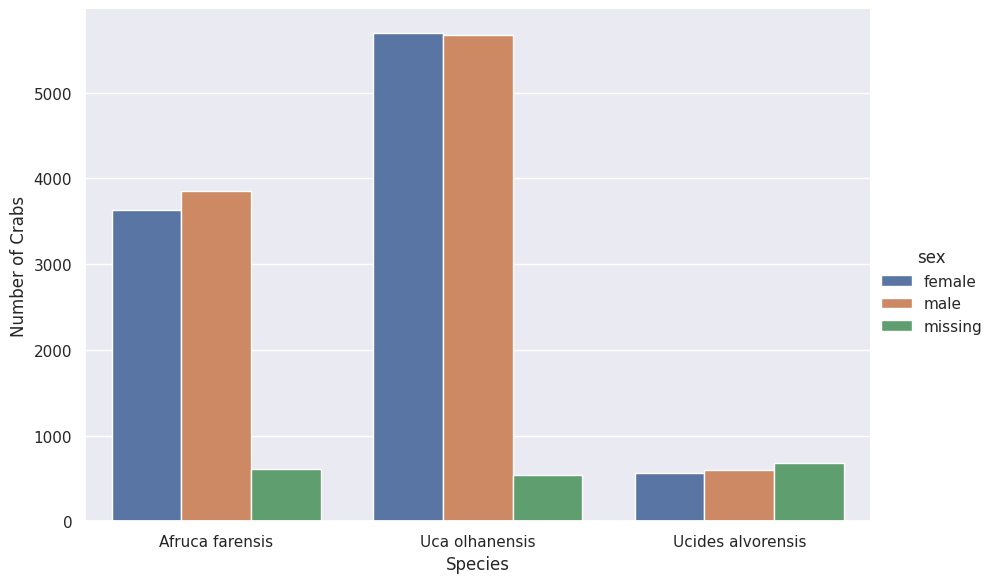

In [ ]:
# Plotting with dodge equivalent
sns.set(style="darkgrid")
g = sns.catplot(
    data=nr_crabs_by_sp_sex,
    kind="bar",
    x="species",
    y="n",
    hue="sex",
    dodge=True,
    height=6,
    aspect=1.5
)
g.set_axis_labels("Species", "Number of Crabs")
g.set_titles("Number of Crabs by Species and Sex")
plt.show()

### Subplots
- split to `plt.subplots`
- or here using single command with catplot

**R code**
```
count(crabs, species, stage) %>%
  ggplot(mapping = aes(x = stage, y = n)) +
  geom_col(position = "dodge2") +
  facet_wrap(vars(species))
```

/tmp/ipython-input-34-562946568.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nr_crabs_by_sp_sex_stage = crabs3.groupby(['species', 'sex', 'stage']).size().reset_index(name='n')


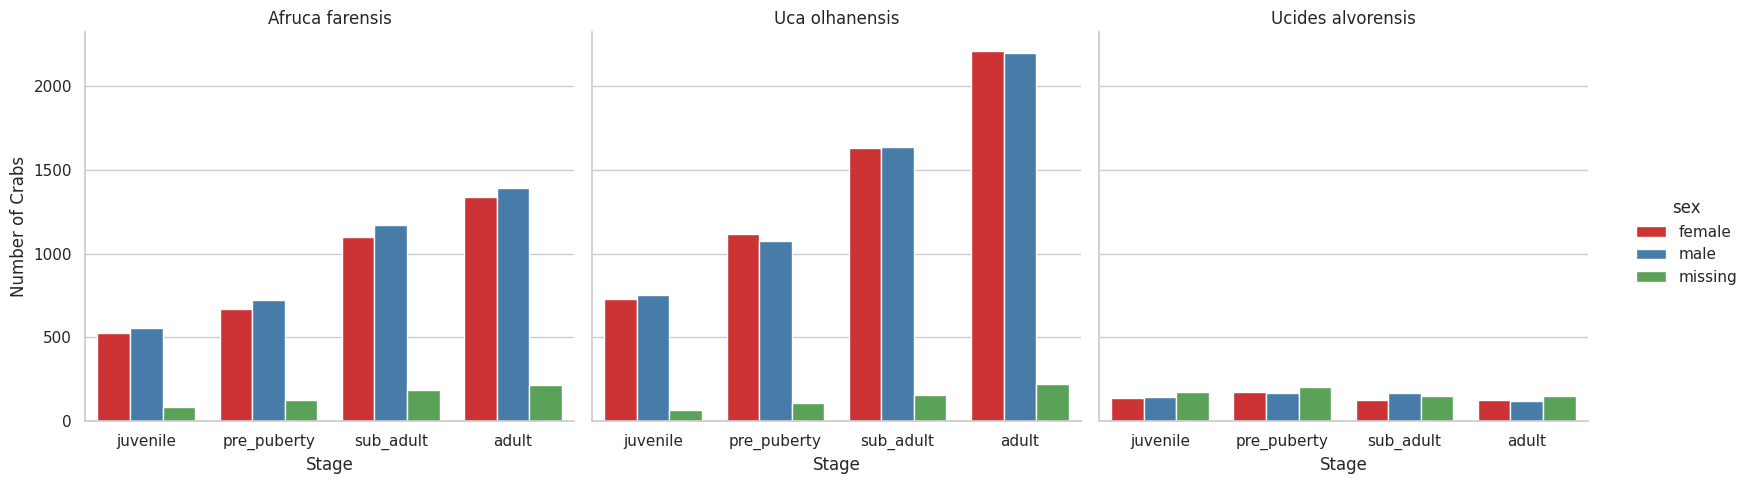

In [ ]:
nr_crabs_by_sp_sex_stage = crabs3.groupby(['species', 'sex', 'stage']).size().reset_index(name='n')

# Plotting with dodge equivalent
sns.set(style="whitegrid")
g = sns.catplot(
    data=nr_crabs_by_sp_sex_stage,
    kind="bar",
    x="stage",
    y="n",
    hue="sex",
    palette="Set1",
    col="species",
    col_wrap=3,
    dodge=True,
    height=5,
    aspect=1.
)
g.set_axis_labels("Stage", "Number of Crabs")
g.set_titles(col_template="{col_name}")
sns.move_legend(g, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()

#### The same but with sex

**R code**
```
ggplot(data = count(crabs3, species, sex, stage), mapping = aes(x = sex, y = n, fill = stage)) +
  geom_col(position = position_dodge2(preserve = "single")) +
  facet_wrap(vars(species))
```

/tmp/ipython-input-35-232620599.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nr_crabs_by_sp_sex_stage = crabs3.groupby(['species', 'sex', 'stage']).size().reset_index(name='n')


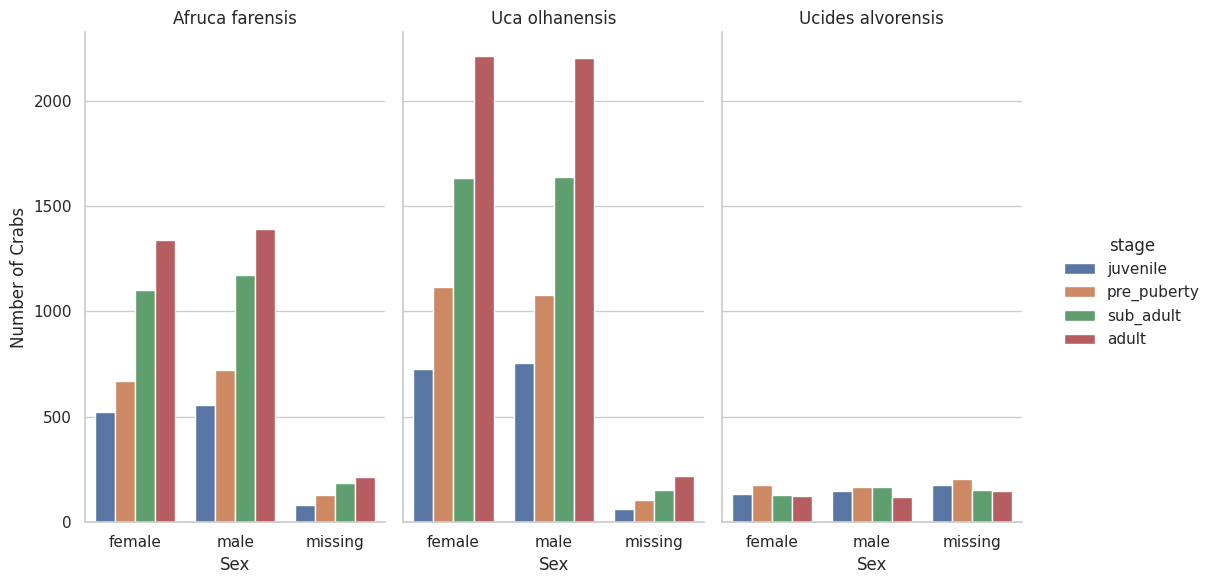

In [ ]:
# Count the number of crabs by species, sex, and stage
nr_crabs_by_sp_sex_stage = crabs3.groupby(['species', 'sex', 'stage']).size().reset_index(name='n')

# Plotting with dodge2-like positioning and facet_wrap
sns.set(style="whitegrid")
g = sns.catplot(
    data=nr_crabs_by_sp_sex_stage,
    kind="bar",
    x="sex",
    y="n",
    hue="stage",
    col="species",
    col_wrap=3,
    dodge=True,
    height=6,
    aspect=0.5
)
g.set_axis_labels("Sex", "Number of Crabs")
g.set_titles(col_template="{col_name}")
sns.move_legend(g, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()

#### Exercise: Convert to percents

/tmp/ipython-input-38-656743684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nr_crabs_by_sp_sex_stage = crabs3.groupby(['species', 'sex', 'stage']).size().reset_index(name='n')
/tmp/ipython-input-38-656743684.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nr_crabs_by_sp_sex_stage.groupby(['species'])['n']


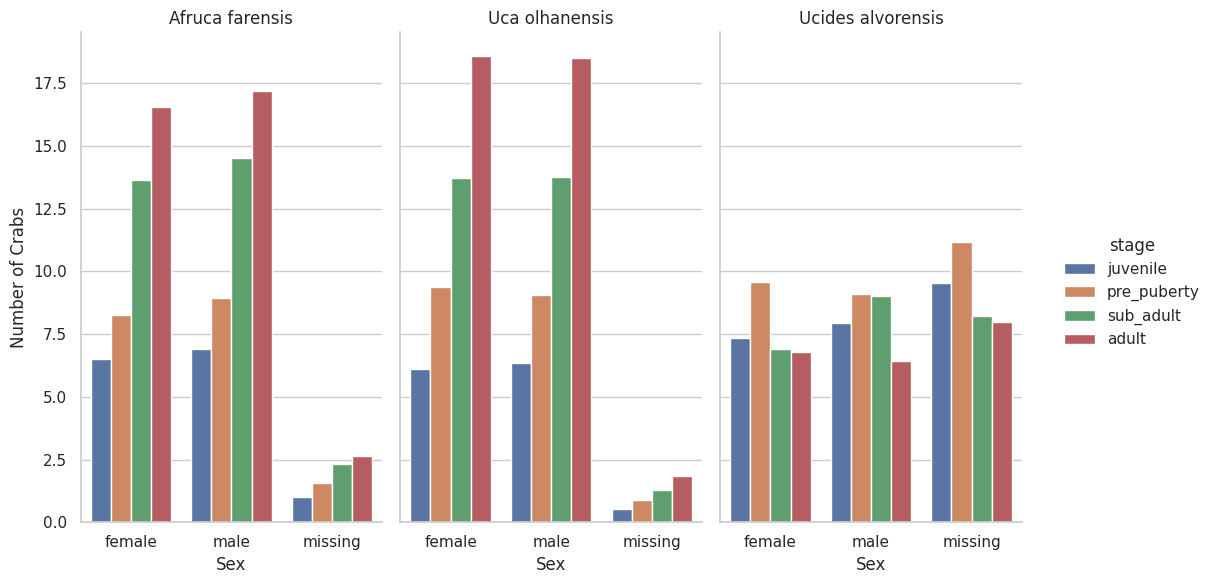

In [ ]:
#@title Solution
# Count the number of crabs by species, sex, and stage
nr_crabs_by_sp_sex_stage = crabs3.groupby(['species', 'sex', 'stage']).size().reset_index(name='n')

nr_crabs_by_sp_sex_stage['pct'] = (
    nr_crabs_by_sp_sex_stage.groupby(['species'])['n']
    .transform(lambda x: 100 * x / x.sum())
)

# Plotting with dodge2-like positioning and facet_wrap
sns.set(style="whitegrid")
g = sns.catplot(
    data=nr_crabs_by_sp_sex_stage,
    kind="bar",
    x="sex",
    y="pct",
    hue="stage",
    col="species",
    col_wrap=3,
    dodge=True,
    height=6,
    aspect=0.5
)
g.set_axis_labels("Sex", "Number of Crabs")
g.set_titles(col_template="{col_name}")
sns.move_legend(g, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout()
plt.show()

## More plot types

### violin

**R code**
```
crabs3 %>%
  drop_na(sex) %>%
  ggplot(mapping = aes(x = stage, y = carapace_width, fill = sex)) +
  geom_violin()
```

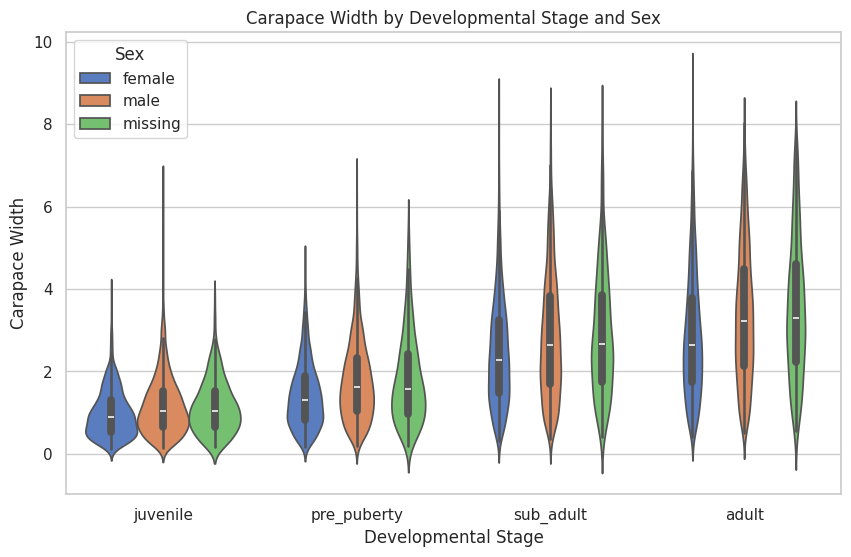

In [ ]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=crabs3, x='stage', y='carapace_width', hue='sex',
               # split=True,
               palette='muted')

# Customize the plot
plt.xlabel('Developmental Stage')
plt.ylabel('Carapace Width')
plt.title('Carapace Width by Developmental Stage and Sex')
plt.legend(title='Sex')
plt.show()

### Density
**R code**

```
crabs3 %>%
  ggplot(mapping = aes(x = carapace_width, fill = sex)) +
  geom_density(alpha=0.8)
```

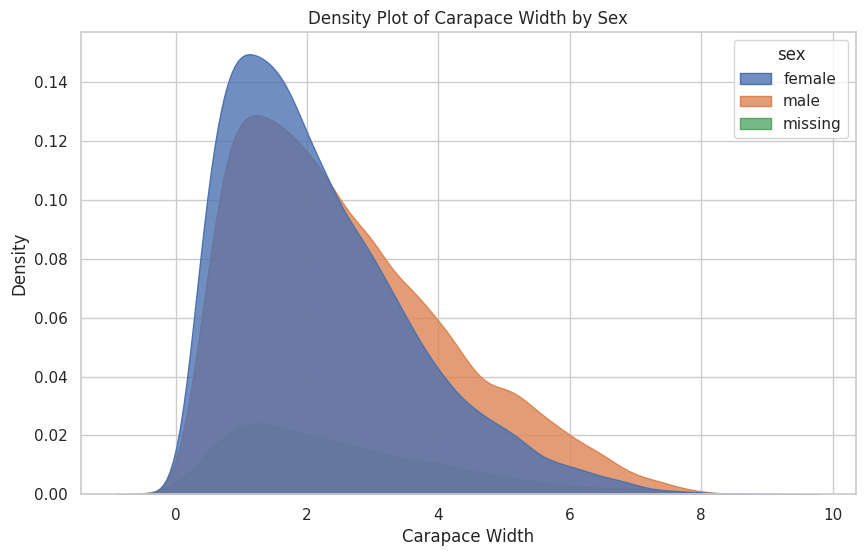

In [ ]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=crabs3, x='carapace_width', hue='sex', fill=True, alpha=0.8)

# Customize the plot
plt.xlabel('Carapace Width')
plt.ylabel('Density')
plt.title('Density Plot of Carapace Width by Sex')
plt.show()

### Histogram

**R code**

```
crabs3 %>%
  ggplot(mapping = aes(x = carapace_width, fill = sex, col = sex)) +
  geom_histogram(alpha=0.8, position = 'identity')
```

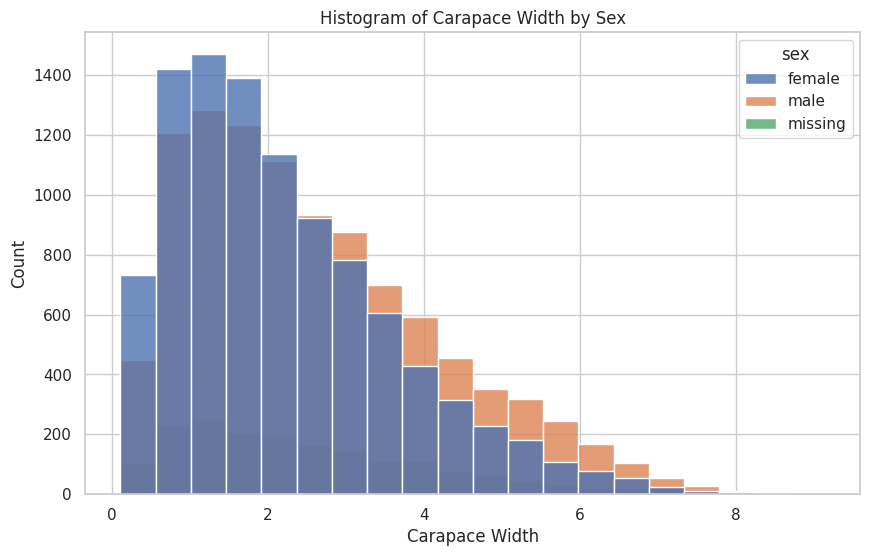

In [ ]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=crabs3, x='carapace_width', hue='sex', fill=True, alpha=0.8, bins=20)

# Customize the plot
plt.xlabel('Carapace Width')
plt.ylabel('Count')
plt.title('Histogram of Carapace Width by Sex')
plt.show()

### Boxplot

**R code**

```
crabs3 %>%
  ggplot(mapping = aes(y = carapace_width, fill = sex)) +
  geom_boxplot()
```

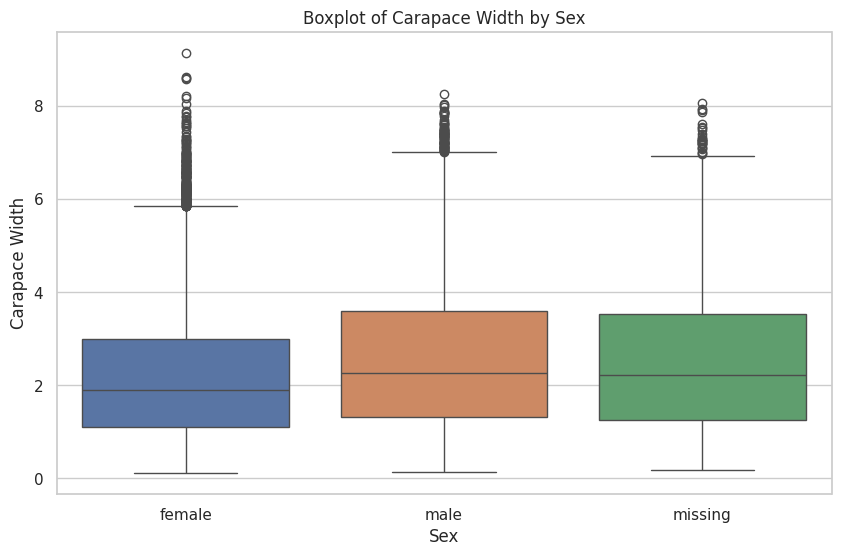

In [ ]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=crabs3, y='carapace_width', x='sex', hue='sex', fill=True)

# Customize the plot
plt.ylabel('Carapace Width')
plt.xlabel('Sex')
plt.title('Boxplot of Carapace Width by Sex')
plt.show()

### Scatter plot

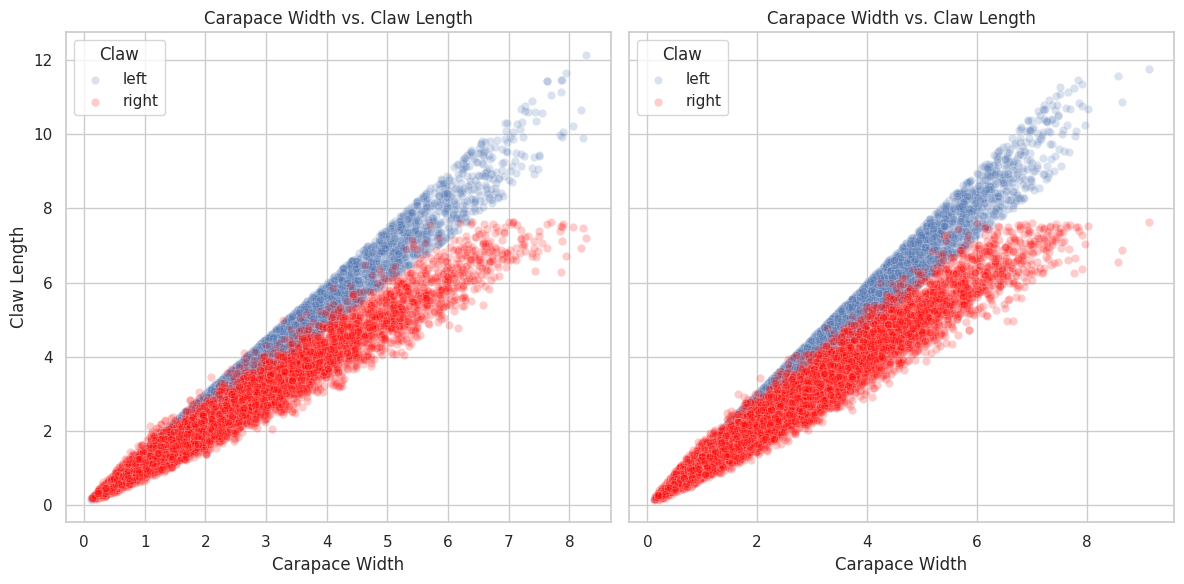

In [ ]:
# Create three separate plots using matplotlib and seaborn
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot 1: carapace_width vs. left_claw_length
# sns.scatterplot(data=crabs, x='carapace_width', y='left_claw_length',
#                 hue='species', palette='tab10', alpha=0.2, ax=axes[0])
sns.scatterplot(data=crabs3[crabs3['species']=='Afruca farensis'],
                x='carapace_width', y='left_claw_length',
                alpha=0.2, ax=axes[0], label='left')
sns.scatterplot(data=crabs3[crabs3['species']=='Afruca farensis'],
                x='carapace_width', y='right_claw_length',
                alpha=0.2, ax=axes[0], color='red', label='right')

axes[0].set_title('Carapace Width vs. Claw Length')
axes[0].set_xlabel('Carapace Width')
axes[0].set_ylabel('Claw Length')
axes[0].legend(title='Claw')

# Plot 2: carapace_width vs. right_claw_length
sns.scatterplot(data=crabs3[crabs3['species']=='Uca olhanensis'],
                x='carapace_width', y='left_claw_length',
                alpha=0.2, ax=axes[1], label='left')
sns.scatterplot(data=crabs3[crabs3['species']=='Uca olhanensis'],
                x='carapace_width', y='right_claw_length',
                alpha=0.2, ax=axes[1], color='red', label='right')
axes[1].set_title('Carapace Width vs. Claw Length')
axes[1].set_xlabel('Carapace Width')
axes[1].set_ylabel('Claw Length')
axes[1].legend(title='Claw')

# Adjust layout
plt.tight_layout()
plt.show()

## Time series

In [ ]:
species_by_time = crabs3.groupby(['date', 'species']).size().unstack()
species_by_time.head()

/tmp/ipython-input-44-3043464357.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_by_time = crabs3.groupby(['date', 'species']).size().unstack()


species,Afruca farensis,Uca olhanensis,Ucides alvorensis
date,,,
2020-01-05,230,316,54
2020-02-23,220,361,47
2020-03-08,215,354,49
2020-04-21,227,341,48
2020-05-31,221,348,42


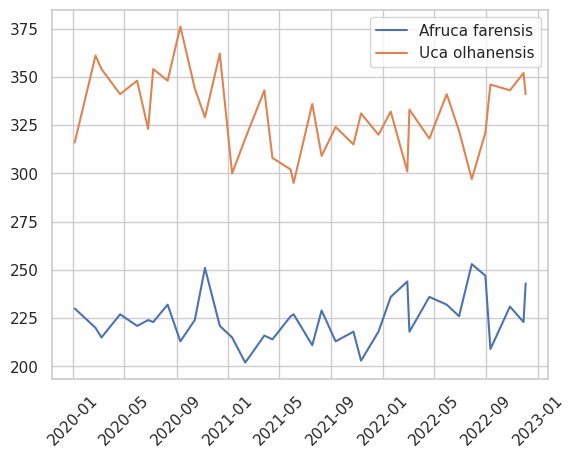

In [ ]:
plt.plot(species_by_time.index, species_by_time['Afruca farensis'])
plt.plot(species_by_time.index, species_by_time['Uca olhanensis'])
plt.xticks(rotation=45)
plt.legend(['Afruca farensis', 'Uca olhanensis'])
plt.show()

In [ ]:
species_by_time = crabs3.groupby(['date', 'region', 'species']).size().unstack()
species_by_time.head()

/tmp/ipython-input-46-1582116541.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_by_time = crabs3.groupby(['date', 'region', 'species']).size().unstack()


species                 Afruca farensis  Uca olhanensis  Ucides alvorensis
date       region                                                         
2020-01-05 Ria Alvor                 97             116                 21
           Ria Formosa              133             200                 33
2020-02-23 Ria Alvor                101             134                 16
           Ria Formosa              119             227                 31
2020-03-08 Ria Alvor                 94             134                 20

In [ ]:
time_evolution = species_by_time.unstack()

In [ ]:
time_evolution.head()

species    Afruca farensis             Uca olhanensis              \
region           Ria Alvor Ria Formosa      Ria Alvor Ria Formosa   
date                                                                
2020-01-05              97         133            116         200   
2020-02-23             101         119            134         227   
2020-03-08              94         121            134         220   
2020-04-21              99         128            119         222   
2020-05-31              82         139            120         228   

species    Ucides alvorensis              
region             Ria Alvor Ria Formosa  
date                                      
2020-01-05                21          33  
2020-02-23                16          31  
2020-03-08                20          29  
2020-04-21                19          29  
2020-05-31                21          21

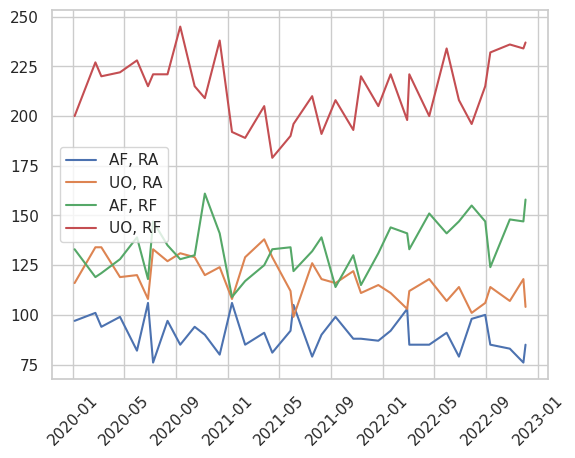

In [ ]:
plt.plot(time_evolution.index, time_evolution['Afruca farensis']['Ria Alvor'], label='AF, RA')
plt.plot(time_evolution.index, time_evolution['Uca olhanensis']['Ria Alvor'], label='UO, RA')

plt.plot(time_evolution.index, time_evolution['Afruca farensis']['Ria Formosa'], label='AF, RF')
plt.plot(time_evolution.index, time_evolution['Uca olhanensis']['Ria Formosa'], label='UO, RF')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# df_melted = df_reset.melt(id_vars=['date', 'region'], var_name='species', value_name='count')
# df_melted.head()